### Quick tutorial on how to perform forced alignment on a piece of a Chinese music

**Check the environments**

In [8]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.5.1
2.5.1
cpu


**Import necessary libraires**

In [9]:
from typing import List

import IPython
import matplotlib.pyplot as plt

**Load the model**

This may take some time, depending on your internet speed.

In [10]:
from torchaudio.pipelines import MMS_FA as bundle

model = bundle.get_model()
model.to(device)

tokenizer = bundle.get_tokenizer()
aligner = bundle.get_aligner()

**Preparing text scripts**

In [15]:
text_raw = "而 我 又 在 待 何 人"
text_normalized = "er wo you zai dai he ren"

**Load & check the audio file**

In [12]:
waveform, sample_rate = torchaudio.load("./1.wav")
waveform = waveform[0:1]
assert sample_rate == bundle.sample_rate

**Define some helper functions**

In [13]:
def compute_alignments(waveform: torch.Tensor, transcript: List[str]):
    with torch.inference_mode():
        emission, _ = model(waveform.to(device))
        token_spans = aligner(emission[0], tokenizer(transcript))
    return emission, token_spans

# Compute average score weighted by the span length
def _score(spans):
    return sum(s.score * len(s) for s in spans) / sum(len(s) for s in spans)


def plot_alignments(waveform, token_spans, emission, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / emission.size(1) / sample_rate

    fig, axes = plt.subplots(2, 1)
    axes[0].imshow(emission[0].detach().cpu().T, aspect="auto")
    axes[0].set_title("Emission")
    axes[0].set_xticks([])

    axes[1].specgram(waveform[0], Fs=sample_rate)
    for t_spans, chars in zip(token_spans, transcript):
        t0, t1 = t_spans[0].start, t_spans[-1].end
        axes[0].axvspan(t0 - 0.5, t1 - 0.5, facecolor="None", hatch="/", edgecolor="white")
        axes[1].axvspan(ratio * t0, ratio * t1, facecolor="None", hatch="/", edgecolor="white")
        axes[1].annotate(f"{_score(t_spans):.2f}", (ratio * t0, sample_rate * 0.51), annotation_clip=False)

        for span, char in zip(t_spans, chars):
            t0 = span.start * ratio
            axes[1].annotate(char, (t0, sample_rate * 0.55), annotation_clip=False)

    axes[1].set_xlabel("time [second]")
    fig.tight_layout()
    
def preview_word(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * spans[0].start)
    x1 = int(ratio * spans[-1].end)
    print(f"{transcript} ({_score(spans):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=sample_rate)

**Preview the audio and the aligned result**

Raw Transcript:  而 我 又 在 待 何 人
Normalized Transcript:  er wo you zai dai he ren


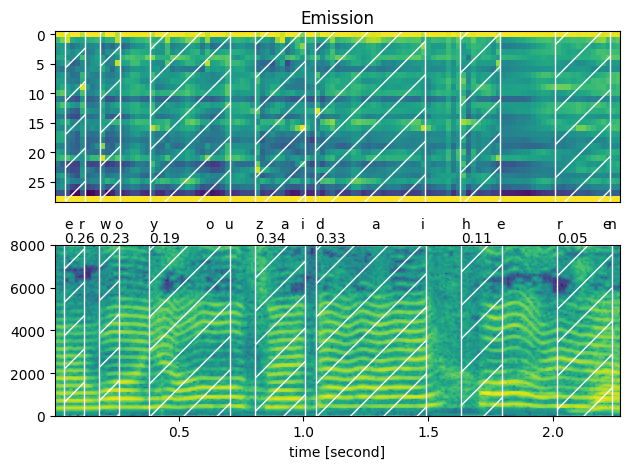

In [16]:
transcript = text_normalized.split()
emission, token_spans = compute_alignments(waveform, transcript)
num_frames = emission.size(1)

plot_alignments(waveform, token_spans, emission, transcript)

print("Raw Transcript: ", text_raw)
print("Normalized Transcript: ", text_normalized)
IPython.display.Audio(waveform, rate=sample_rate)


**Preview a single word**

In [17]:
preview_word(waveform, token_spans[2], num_frames, transcript[2])

you (0.19): 0.383 - 0.706 sec
